In [2]:
import seaborn as sns
from datetime import datetime
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import geopandas as gpd
from dateutil.parser import parse
from sklearn.metrics import silhouette_score

ProgressBar().register()

In [62]:
taxi_zones = gpd.read_file('data/taxi_zones__7_/taxi_zones.shp')

In [3]:
FHV = dd.read_csv('Data/May_to_Aug_FHV_Data.csv')
FHV = FHV.drop(columns='Unnamed: 0').reset_index(drop=True)

In [4]:
FHV.PUTime = dd.to_datetime(FHV.PUTime)
FHV.DOTime = dd.to_datetime(FHV.DOTime)

In [5]:
FHV['Hour'] = FHV.PUTime.dt.hour
FHV['DOW'] = FHV.PUTime.dt.dayofweek

In [6]:
FHV['overnight'] = 0

In [7]:
FHV['overnight'] = FHV['overnight'].mask(((FHV['Hour'] > 0) & (FHV['Hour'] < 6)), 1)

In [8]:
FHV = FHV[(FHV['Duration'] >= 5) & (FHV['Duration'] <= 90)].compute() # Only keep rides between 5 minutes and 2.5 hours

[########################################] | 100% Completed |  1min 32.2s


In [9]:
FHV = FHV[~((FHV['PULocationID'] == 1) | (FHV['DOLocationID'] == 1))] # Drop all trips to and from Newark
FHV = FHV[~((FHV['PULocationID'] == 132) | (FHV['DOLocationID'] == 132))] # Drop all trips to and from JFK
FHV = FHV[~((FHV['PULocationID'] == 138) | (FHV['DOLocationID'] == 138))] # Drop all trips to and from LaGuardia


In [12]:
FHV.PULocationID.nunique()

259

In [14]:
FHV[FHV['overnight']==1]['Duration'].mean()

15.210310876753745

Text(0.5, 1.0, 'Total Log Distribution of Ride Duration')

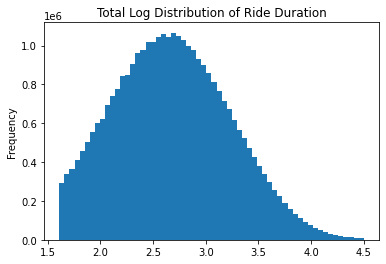

In [15]:
np.log(FHV['Duration']).plot.hist(bins=60)
plt.title('Total Log Distribution of Ride Duration')

Text(0.5, 1.0, 'Distribution of Overnight and Non-Overnight Ride Duration \n')

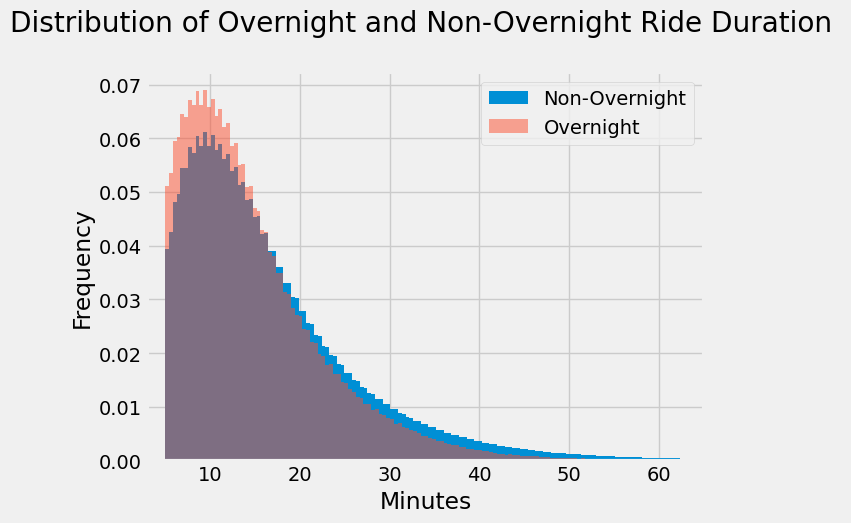

In [79]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

FHV['Duration'].plot.hist(bins=200, ax=ax, label='Non-Overnight',density=True)
FHV[(FHV['overnight'] == 1)]['Duration'].plot.hist(bins=200, alpha=.5, ax=ax, label='Overnight', density=True)
ax.legend()
ax.set_xlabel('Minutes')
ax.set_xlim(3,65)

plt.title('Distribution of Overnight and Non-Overnight Ride Duration \n')

In [19]:
from scipy import stats
stats.ttest_ind((FHV[(FHV['overnight'] == 1)]['Duration']), FHV['Duration'])

Ttest_indResult(statistic=-287.59531758431274, pvalue=0.0)

In [28]:
FHV.shape

(31988933, 9)

In [20]:
for c in FHV['Company'].unique():
    print(c,'total ride percentage:', len(FHV[FHV['Company']==c]) / len(FHV))
    print(c,'overnight percentage:', len(FHV[(FHV['overnight']==1) & (FHV['Company']==c)]) / len(FHV[(FHV['overnight']==1)]))
    print('\n')


Uber total ride percentage: 0.6986454850891711
Uber overnight percentage: 0.6835370567776377


Via total ride percentage: 0.01677613785813906
Via overnight percentage: 0.010450095947343103


Lyft total ride percentage: 0.2845783770526898
Lyft overnight percentage: 0.3060128472750192




In [83]:
ride_ratio = []
for c in ['Uber','Lyft','Via']:
    total_pct = len(FHV[(FHV['overnight']==0) & (FHV['Company']==c)]) / len(FHV[(FHV['overnight']==0)])
    overnight_pct = len(FHV[(FHV['overnight']==1) & (FHV['Company']==c)]) / len(FHV[(FHV['overnight']==1)])
    ride_ratio.append([c, total_pct, overnight_pct])
    

In [148]:
rides_by_company = pd.DataFrame(ride_ratio, columns=['Company','Non-Overnight','Overnight'])

In [149]:
rides_by_company.set_index('Company')

,Non-Overnight,Overnight
Company,,
Uber,0.700606,0.683625
Lyft,0.282068,0.305893
Via,0.017327,0.010482


(array([0, 1, 2]), [Text(0, 0, 'Uber'), Text(1, 0, 'Lyft'), Text(2, 0, 'Via')])

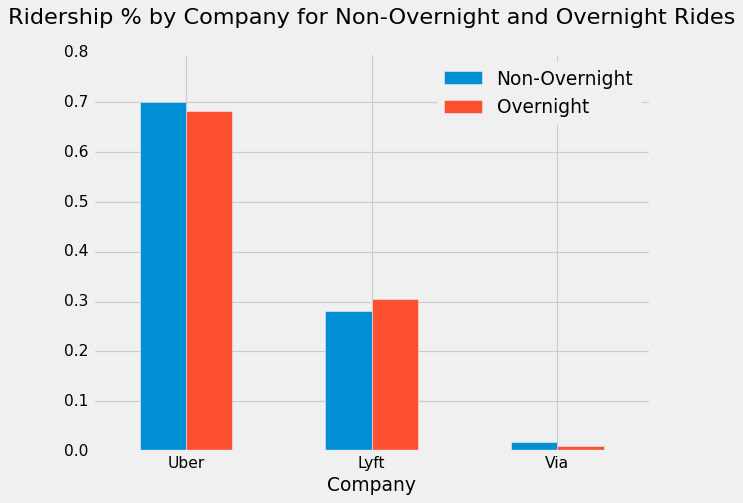

In [150]:
rides_by_company.set_index('Company').plot.bar()
plt.title('Ridership % by Company for Non-Overnight and Overnight Rides\n')
plt.xticks(rotation=0)

In [24]:
FHV[FHV['overnight']==1].groupby(['PULocationID','DOLocationID'])['Company'].count().sort_values(ascending=False)

PULocationID  DOLocationID
76            76              6699
61            61              4857
35            76              4620
76            35              3909
39            76              3670
                              ... 
150           209                1
              208                1
              203                1
              192                1
2             28                 1
Name: Company, Length: 48641, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

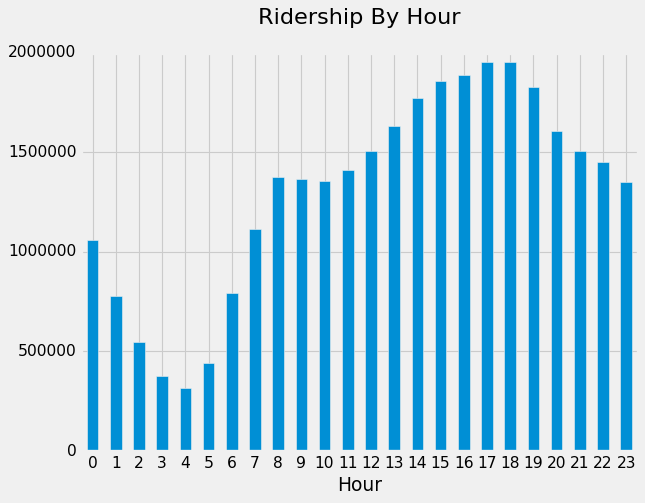

In [123]:
FHV.groupby('Hour')['DOW'].count().plot.bar()
plt.title('Ridership By Hour\n')
plt.xticks(rotation=0)

In [19]:
FHV_DOW = FHV.groupby(['DOW','overnight'])['Hour'].count().unstack()

In [20]:
FHV_DOW.columns.name=''
FHV_DOW.columns = ['Non-Overnight','Overnight']


In [27]:
day_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat', 6:'Sun'}

In [32]:
FHV_DOW['DOW'] = FHV_DOW.index.to_series().map(day_dict)

In [35]:
FHV_DOW = FHV_DOW.set_index('DOW')

Text(0, 0.5, 'count')

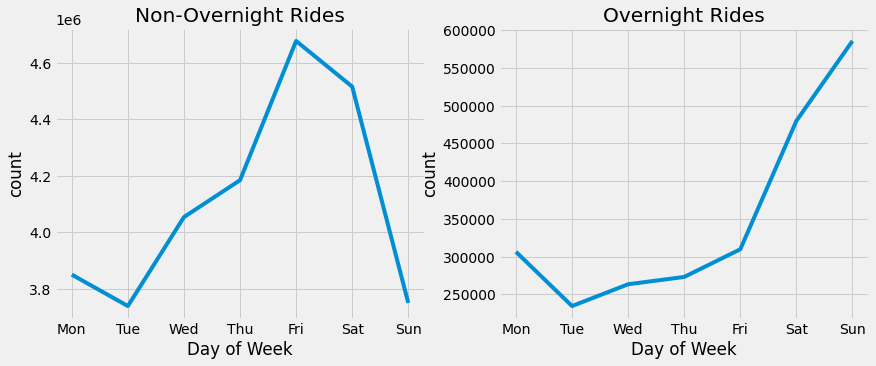

In [48]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

FHV_DOW['Non-Overnight'].plot(ax=ax[0])
ax[0].set_title('Non-Overnight Rides')
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('count')

FHV_DOW['Overnight'].plot(ax=ax[1])
ax[1].set_title('Overnight Rides')
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('count')

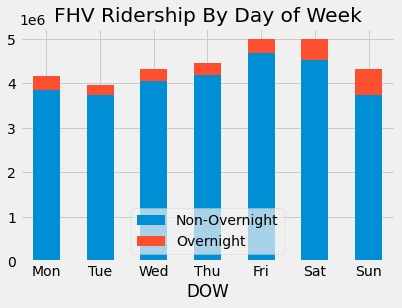

In [38]:
FHV_DOW.plot.bar(stacked=True)
plt.legend(loc='lower center', framealpha=0.7)
plt.title('FHV Ridership By Day of Week')
plt.xticks(rotation=0)
plt.show()

In [ ]:
taxi_zones.merge(zone_acs, left_on='LocationID', right_on='LocationID', how='left').plot('essential_workers', ax=ax[1])


NameError: name 'taxi' is not defined

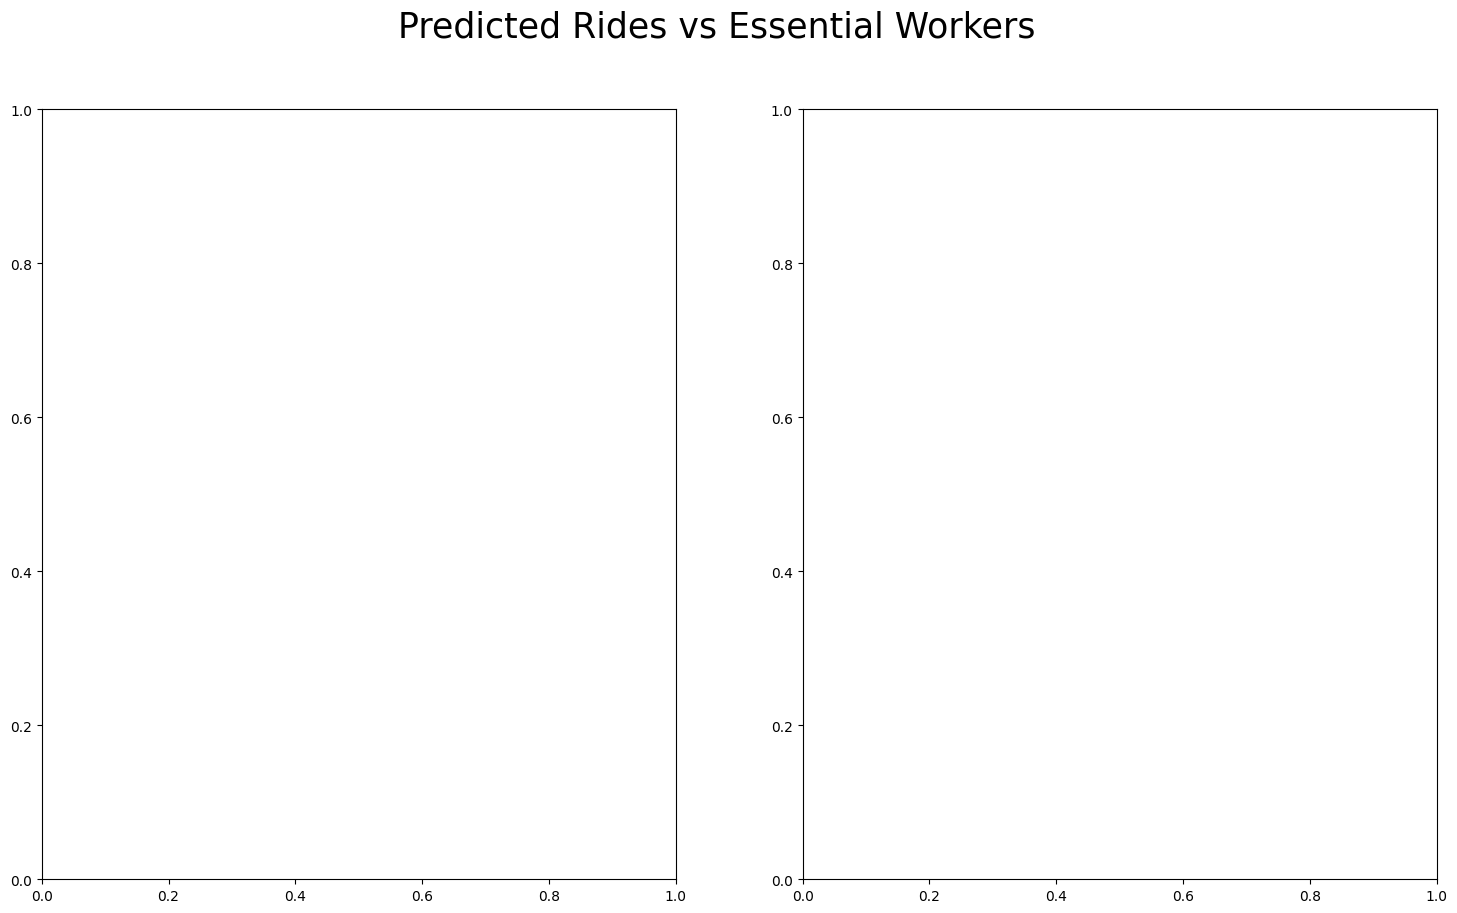

In [68]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(1,2,figsize=(18,10))
plt.suptitle('Predicted Rides vs Essential Workers', fontsize=25)
taxi.merge(rides_count, on='LocationID', how='right').plot('PredRidesPct', ax=ax[0], cmap='magma')
ax[0].set_title('Predicted Overnight Rides - Normalized', fontsize=15)
ax[0].axis('off')
taxi_zones.merge(zone_acs, left_on='LocationID', right_on='LocationID', how='left').plot('essential_workers', ax=ax[1])
ax[1].set_title('Essential Workers Count', fontsize=15)
ax[1].axis('off')

#fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70)

plt.show()

taxi_zones.merge(zone_acs, left_on='LocationID', right_on='LocationID', how='left').plot('essential_workers')

In [17]:
pd.get_dummies(FHV['PULocationID']).join(pd.get_dummies(FHV['DOLocationID']), lsuffix='PU', rsuffix='DO')

KeyboardInterrupt: 

In [38]:
non_overnight_pickups = FHV[FHV['overnight']==0].PULocationID.value_counts()
non_overnight_pickups = non_overnight_pickups.reset_index()

In [69]:
overnight_pickups = FHV[FHV['overnight']==1].PULocationID.value_counts()

In [70]:
overnight_pickups = overnight_pickups.reset_index()

NameError: name 'im' is not defined

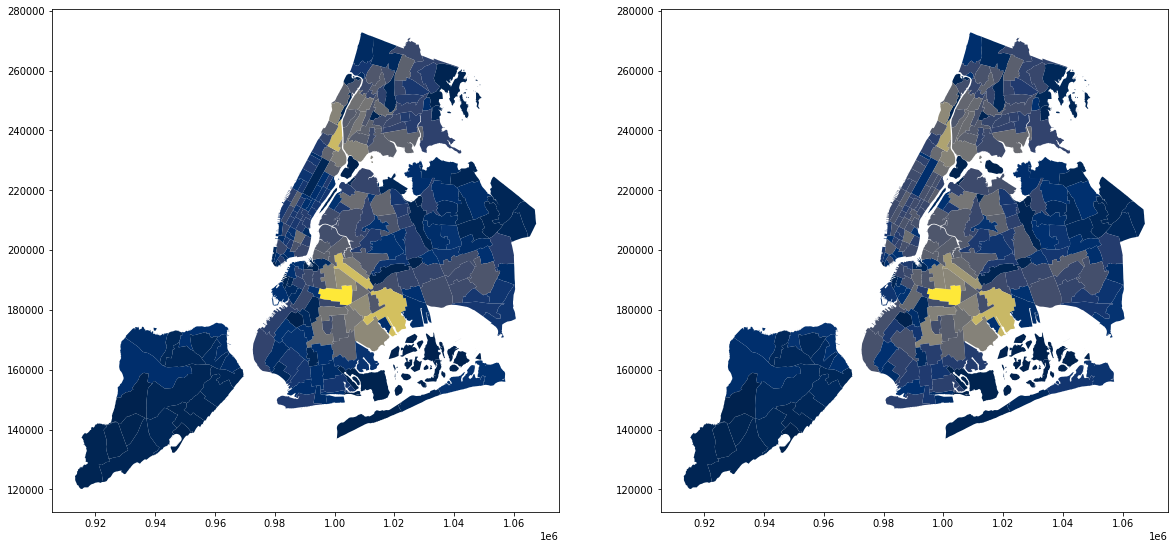

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))

taxi_zones.merge(overnight_pickups, left_on='LocationID', right_on='index', how='left').plot('PULocationID', ax=ax1,\
 cmap='cividis')   

taxi_zones.merge(non_overnight_pickups, left_on='LocationID', right_on='index', how='left').plot('PULocationID', ax=ax2,\
 cmap='cividis')   

plt.colorbar(im,fraction=0.046, pad=0.04)

In [83]:
ride_pct_change = ((FHV[FHV['overnight']==1].PULocationID.value_counts() \
                    - FHV[FHV['overnight']==0].PULocationID.value_counts())/\
                   FHV[FHV['overnight']==0].PULocationID.value_counts())

In [88]:
ride_pct_change = ride_pct_change.reset_index()

In [3]:

taxi_zones.merge(ride_pct_change, left_on='LocationID', right_on='index').plot('PULocationID', scheme='quantiles',\
legend=True, cmap='Reds_r', legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1)), figsize=(10,10))
plt.title('Percent Ridership Decrease During Overnight Hours\n', fontsize=20)
plt.show()

NameError: name 'taxi_zones' is not defined

### Merging ACS and subway ridership data with FHV Data

In [33]:
# Import pct_change in subway ridership from May through August between 2019 and 2020

subway = pd.read_csv('MLC_data-main 3/data/ridership_by_taxizone/ridership_by_taxizone.csv')
subway = subway.drop(columns=['Unnamed: 0', '2019_entries', '2019_exits','2020_entries','2020_exits'])
subway['mean_pct_change'] = (subway['entries__pct_change'] + subway['exits_pct_change']) / 2

In [34]:
subway['subway'] = 1
subway['subway'] = subway['subway'].mask(subway.isna().any(axis=1), 0)
subway = subway.drop(columns=['entries__pct_change','exits_pct_change','mean_pct_change'])

In [50]:
# Import 2019 ACS variables for census_tracts and taxi

acs = pd.read_csv('MLC_data-main 3/data/census_zones/census_zones.csv')

In [51]:
# select relevant variables from ACS table

acs_var_names = {'healthcare':'SE_B17008_004','food_service':'SE_B17008_006','maintenance':'SE_B17008_007',\
                 'retail_sales':'SE_B17008_009', 'race_white':'SE_A03001_002', 'hh_median_income':'SE_A14006_001',\
                 'transit_commute':'SE_A09005_003','transit_12_5':'ACS19_5yr_B08132047','transit_60min+':'ACS19_5yr_B08134070'}

acs_var_names = {v: k for k, v in acs_var_names.items()}

acs_vars = [s.strip() for s in list(acs_var_names.keys())]

In [52]:
pd.DataFrame.from_dict(acs_var_names, orient='index')

,0
SE_B17008_004,healthcare
SE_B17008_006,food_service
SE_B17008_007,maintenance
SE_B17008_009,retail_sales
SE_A03001_002,race_white
SE_A14006_001,hh_median_income
SE_A09005_003,transit_commute
ACS19_5yr_B08132047,transit_12_5
ACS19_5yr_B08134070,transit_60min+


In [53]:
zone_acs1 = acs[['LocationID'] + acs_vars].groupby('LocationID').sum().drop(columns='SE_A14006_001')
zone_acs2 = acs[['LocationID','SE_A14006_001']].groupby('LocationID').mean()
zone_acs = zone_acs1.merge(zone_acs2, on='LocationID').fillna(0)

In [54]:
zone_acs.head()

,SE_B17008_004,SE_B17008_006,SE_B17008_007,SE_B17008_009,SE_A03001_002,SE_A09005_003,ACS19_5yr_B08132047,ACS19_5yr_B08134070,SE_A14006_001
LocationID,,,,,,,,,
2.0,0,0,0,0,0,0,0,0,0.000000
3.0,794,531,697,1183,9220,5752,198,3922,78678.545455
4.0,643,512,394,1357,10121,7346,158,1255,48225.166667
5.0,361,290,258,1455,24498,2602,28,2322,91298.500000
6.0,334,409,182,565,11378,2640,36,1767,78611.000000


In [55]:
zone_acs.columns = [acs_var_names[x] for x in zone_acs.columns]

In [56]:
zone_acs['essential_workers'] = zone_acs.iloc[:,:4].sum(axis=1)

In [57]:
zone_acs = zone_acs.reset_index().drop(columns=['healthcare','food_service','maintenance','retail_sales'])

In [78]:
zone_acs[57:70]

,LocationID,race_white,transit_commute,transit_12_5,transit_60min+,hh_median_income,essential_workers
57,60.0,2352,5441,386,2348,27391.666667,3129
58,61.0,24225,39830,1379,11391,51373.629630,12958
59,62.0,14384,12862,309,3568,56083.666667,5330
60,63.0,18735,13827,491,4605,52956.066667,6841
61,64.0,13051,3791,21,2813,103640.333333,2205
62,65.0,5294,5220,3,263,113086.000000,1154
63,66.0,4425,3210,33,441,123331.500000,828
64,67.0,20853,9283,131,4787,71832.000000,5633
65,68.0,20417,10458,0,1165,88980.500000,3697
66,69.0,8405,17493,906,6858,33030.307692,10351


In [43]:
#merge FHV data with ACS variables by Taxi Zone

FHV_merged = FHV.merge(zone_acs, left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(zone_acs, left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')

KeyboardInterrupt: 

In [44]:
#merge FHV data with Subway binary

FHV_merged = FHV.merge(subway, left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(subway, left_on='DOLocationID', right_on='LocationID', how='left')

In [45]:
dummies = pd.get_dummies(FHV_merged['DOW']).join(pd.get_dummies(FHV_merged['Company']))

In [46]:
FHV_merged = FHV_merged.drop(columns=['Hour','DOW','Company','LocationID']).join(dummies)

In [16]:
FHV_merged[(FHV_merged['PULocationID'] == 132)]

NameError: name 'FHV_merged' is not defined

In [66]:
FHV_merged.to_csv('FHV_ridership_dummies_no_acs.csv', index=False)

In [66]:
FHV_merged = FHV_merged.drop(columns=['DOTime','PUTime','LocationID'])

In [ ]:
FHV_merged.head()

### Exploratory Data Analysis


In [23]:
def green_over_one(val):
    color = '' if val < 1 else 'honeydew'
    return 'background-color: %s' % color

In [24]:
(FHV_merged.iloc[:,7:].groupby('overnight').mean() / FHV_merged.iloc[:,7:].mean())\
    .drop(columns=['overnight','DOW']).transpose().rename(columns={0:'no', 1:'yes'}).style.applymap(green_over_one)

overnight,no,yes
DO_subway_decrease,1.001739,0.979534
PU_subway_decrease,1.001563,0.981608
essential_workers_x,0.993465,1.076906
essential_workers_y,0.992876,1.083840
hh_median_income_x,1.008868,0.895634
hh_median_income_y,1.009659,0.886333
race_white_x,1.005129,0.939644
race_white_y,1.004962,0.941601
transit_12_5_x,0.988893,1.130715
transit_12_5_y,0.988699,1.132999


In [136]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: honeydew' if v else '' for v in is_max]

In [28]:
overnight_means = FHV_merged.iloc[:,7:].groupby('overnight').mean().drop(columns='DOW').rename(columns={0:'no', 1:'yes'}).style.apply(highlight_max)
overnight_means

,race_white_x,transit_commute_x,transit_12_5_x,transit_60min+_x,hh_median_income_x,essential_workers_x,race_white_y,transit_commute_y,transit_12_5_y,transit_60min+_y,hh_median_income_y,essential_workers_y,PU_subway_decrease,DO_subway_decrease
overnight,,,,,,,,,,,,,,
0,17369.079957,14395.191822,396.140011,4495.116887,75056.597929,6033.633454,17368.741893,14338.894087,394.178728,4487.964693,75444.121915,6012.934114,-0.622445,-0.622435
1,16237.476170,15155.413177,452.952665,4930.146954,66632.324298,6540.398088,16273.667607,15088.833971,451.708951,4955.193199,66228.963902,6563.818107,-0.610043,-0.608638


In [718]:
FHV_merged[FHV_merged['overnight']==1].iloc[:,9:].mean()

pct_white_x              16760.857125
pct_transit_commute_x    15034.838875
transit_12_5_x             432.712749
transit_60min+_x          4760.663858
hh_median_income_x       70871.312334
essential_workers_x       6308.321230
pct_white_y              16868.007536
pct_transit_commute_y    14856.445071
transit_12_5_y             425.826427
transit_60min+_y          4760.834645
hh_median_income_y       70702.399080
essential_workers_y       6293.211836
PU_subway_change            -0.619228
DO_subway_change            -0.615850
dtype: float64

In [107]:
FHV['Month'] = FHV.PUTime.dt.month

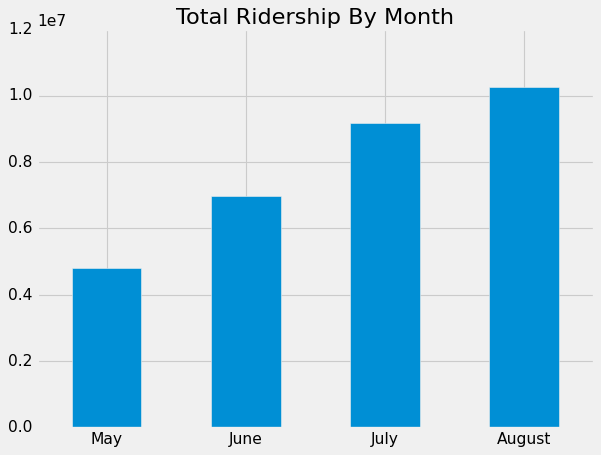

In [108]:
fig, ax = plt.subplots()

FHV['Month'].value_counts(ascending=True).plot.bar(ax=ax, label='Total')

ax.set_xticklabels(['May','June','July','August'], rotation=0)
plt.title("Total Ridership By Month")
plt.show()

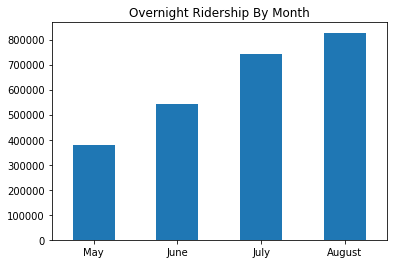

In [245]:
fig, ax = plt.subplots()

FHV[FHV['overnight'] ==1]['Month'].value_counts(ascending=True).plot.bar(ax=ax, label='Overnight')

ax.set_xticklabels(['May','June','July','August'], rotation=0)
plt.title("Overnight Ridership By Month")
plt.show()

In [68]:
DO_clusters = pd.read_csv('data/DO_Mobility_clusters.csv')
PU_clusters = pd.read_csv('data/PU_Mobility_clusters.csv')

In [71]:
PU_clusters.iloc[:,1:]

,overnight,subway_x,0,1,2,3,4,5,6,Lyft,Uber,Via,ride_count,bus_stop_count
0,9476.793103,128400.195402,18215.712644,17469.908046,18986.770115,19555.873563,21461.977011,20755.563218,18049.103448,35943.252874,95697.149425,2854.505747,134494.908046,0.160920
1,19877.950000,232192.500000,30179.025000,28815.775000,31517.700000,32678.050000,37369.075000,38344.450000,33288.425000,65897.500000,162536.775000,3758.225000,232192.500000,0.650000
2,37691.916667,408200.166667,53515.500000,51015.166667,55375.833333,57420.166667,65123.833333,66819.333333,58930.333333,128608.583333,273189.916667,6401.666667,408200.166667,0.750000
3,2975.636364,27827.454545,6196.000000,5866.727273,6384.181818,6546.454545,7100.272727,6817.909091,5968.545455,13549.818182,30784.000000,546.272727,44880.090909,2.909091
4,2924.726415,31349.707547,5400.820755,5083.396226,5471.169811,5623.028302,6228.650943,6184.509434,5413.339623,10761.613208,28199.452830,443.849057,39404.915094,0.028302
